Run this notebook to

- Merge all partner epochs from all participants and all sessions and save merged epochs file
- Plot FRN for agree vs disagree trials
- Plot FRN for agree vs disagree trials split by partner condition
- Plot FRN for lower than median vs higher than median confidence 
- Plot FRN for lower than median vs higher than median confidence split by partner condition
- Plot all of the above separately for the strategic and observational conditions


## Import stuff

In [1]:
import os
import numpy as np
import mne
from mne.stats import permutation_t_test
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr 

million = 1000000.


#%matplotlib qt
%matplotlib inline

input_dir = 'TaskpartnerEpochsMastoids'


In [2]:
def load_subj_eeg(path, file, downsample=None):
    fp = os.path.join(path, '%s-epo.fif' % file)
    print('>>> Loading %s' % fp)
    epochs = mne.read_epochs(fp, preload=True)
    if downsample is not None:
        epochs = epochs.resample(downsample)
    return epochs

def load_all_eeg(path, files, downsample=None):
    subject_epochs = [load_subj_eeg(path, file, downsample=downsample) for file in files]
    epochs = mne.epochs.concatenate_epochs(subject_epochs)
    return epochs

## Merge epochs

In [3]:
participant_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]

sessions = [1, 2]

participant_files = []

for session in sessions:
    for subject in participant_numbers:
        participant_files.append('%i_%i' % (subject, session))

In [4]:
remerge = True
if remerge:
    partner_epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    partner_epochs.save('mergedData/partner_epoch_mastoids-epo.fif', overwrite=True)
else:
    partner_epochs = mne.read_epochs('mergedData/partner_epoch_mastoids-epo.fif')
    
partner_epochs = partner_epochs.pick_types(eeg=True)
data = partner_epochs.metadata

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\1_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\2_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\

    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
298 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/21_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\21_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
293 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\1_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compe

        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/19_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\19_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/20_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\20_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 b

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


Adding metadata with 51 columns
11789 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Overwriting existing file.


C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\4174112270.py:4: RuntimeWarning: epochs.drop_log contains 101546 entries which will incur up to a 1.3 MB writing overhead (per split file), consider using epochs.reset_drop_log_selection() prior to writing
  partner_epochs.save('mergedData/partner_epoch_mastoids-epo.fif', overwrite=True)


In [5]:
def plot_joint(erp, times, title='', width=12, height=8, invert=True, save=None):
    fig = erp.plot_joint(times=times,
                         show=False,
                         ts_args=dict(time_unit='s'),
                         topomap_args=dict(res=128, contours=4, time_unit='s'),
                         title=title)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    axes = fig.get_axes()
    ax0 = axes[0]
    if invert:
        ax0.invert_yaxis()
    ch = ax0.get_children()
    for c in ch:
        if type(c) == plt.Annotation:
            c.remove()
        if type(c) == plt.Line2D:
            c.set_linewidth(2.5)
            c.set_alpha(.75)
    leg_ax = axes[-2]
    leg_ax.get_children()[0].set_sizes([50.])
    leg_ax.set_aspect('equal')
    if save is not None:
        fig.savefig(save)
    fig.show()


No projector specified for this dataset. Please consider the method self.add_proj.


C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\56482209.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


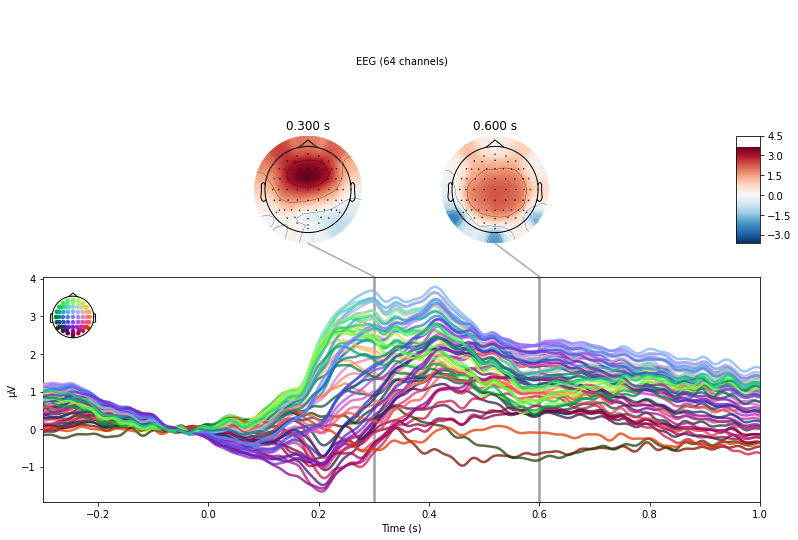

In [6]:
erp = partner_epochs.copy().average()
plot_joint(erp, [0.3, 0.6], invert=False)
plt.savefig('Figures/all channels_partner_epoch.pdf')

## agree vs disagree grand average (first calculating each participant's average)

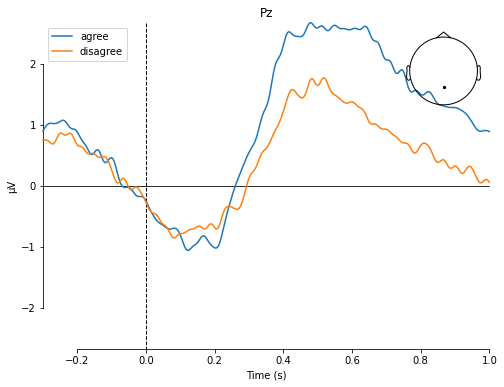

[<Figure size 576x432 with 2 Axes>]

In [7]:
# P3

grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())



evokeds = dict(agree=grand_average_agree,
               disagree=grand_average_disagree)



# Plot the grand averages with shaded standard error of the mean
mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False, ci=False)


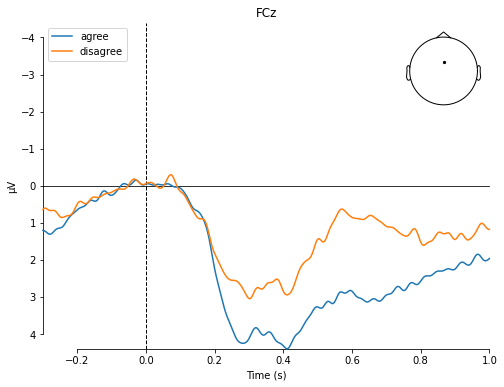

[<Figure size 576x432 with 2 Axes>]

In [8]:
# FRN

grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())



evokeds = dict(agree=grand_average_agree,
               disagree=grand_average_disagree)



# Plot the grand averages with shaded standard error of the mean
mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=True, ci=False)


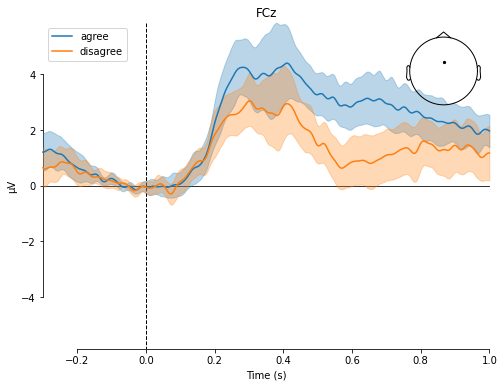

[<Figure size 576x432 with 2 Axes>]

In [9]:
grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())



evokeds = dict(agree=grand_average_agree,
               disagree=grand_average_disagree)



# Plot the grand averages with shaded standard error of the mean
mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False, ci=0.95)




## agree vs disagree split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


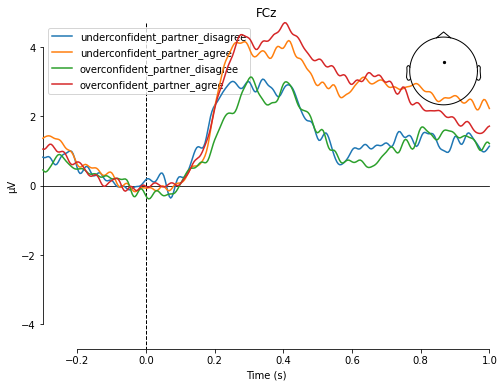

[<Figure size 576x432 with 2 Axes>]

In [10]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']



for subject in participant_numbers:    
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())

grand_average_underconf_agree = mne.grand_average(grand_average_underconf_agree)
grand_average_underconf_disagree = mne.grand_average(grand_average_underconf_disagree)
grand_average_overconf_agree = mne.grand_average(grand_average_overconf_agree)
grand_average_overconf_disagree = mne.grand_average(grand_average_overconf_disagree)


evokeds = dict(underconfident_partner_disagree=grand_average_underconf_disagree,
               underconfident_partner_agree=grand_average_underconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## Low vs high confidence grand average 

In [11]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
partner_epochs.metadata['confidence_z_by_participant'] = partner_epochs.metadata['participant_confidence'].groupby(partner_epochs.metadata['participant']).transform(zscore)
        
median_confidence = partner_epochs.metadata['confidence_z_by_participant'].median()


Identifying common channels ...
Identifying common channels ...


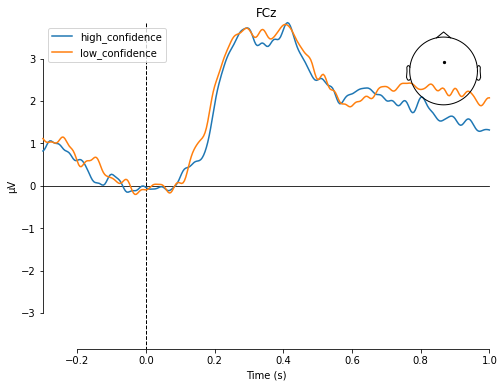

[<Figure size 576x432 with 2 Axes>]

In [12]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = partner_epochs['confidence_z_by_participant > 0']
low_conf_epochs = partner_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


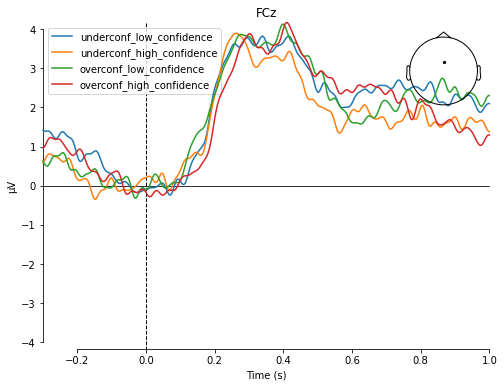

[<Figure size 576x432 with 2 Axes>]

In [13]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


In [14]:
partner_epochs_copy = partner_epochs

In [15]:
roi = ["Cz", "FCz", "Pz", "FC1", "FC2"]

# Strategic condition

In [16]:
partner_epochs = partner_epochs_copy['condition == "s"']

## agree vs disagree grand average (first calculating each participant's average)

Identifying common channels ...
Identifying common channels ...


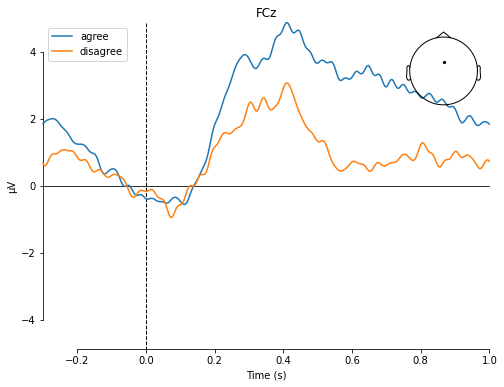

[<Figure size 576x432 with 2 Axes>]

In [17]:
grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())


grand_average_agree = mne.grand_average(grand_average_agree)
grand_average_disagree = mne.grand_average(grand_average_disagree)

evokeds = dict(agree=grand_average_agree,
               disagree=grand_average_disagree)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## agree vs disagree split by partner grand average 


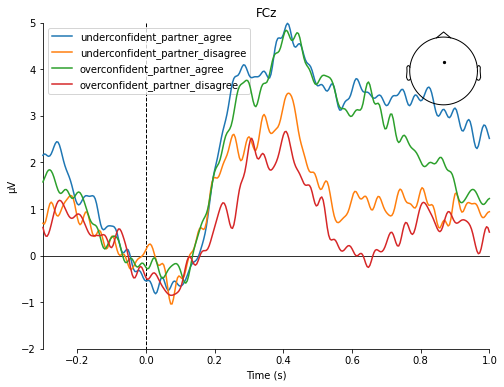

In [18]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)



fig = mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))
fig[0].savefig('Figures/normative_feedback_partner_FCz.pdf', bbox_inches='tight')


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\1280235701.py:30: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks='Pz', invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))


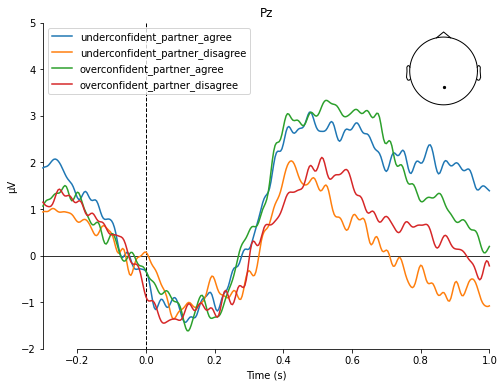

[<Figure size 576x432 with 2 Axes>]

In [19]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)

mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks='Pz', invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))




combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


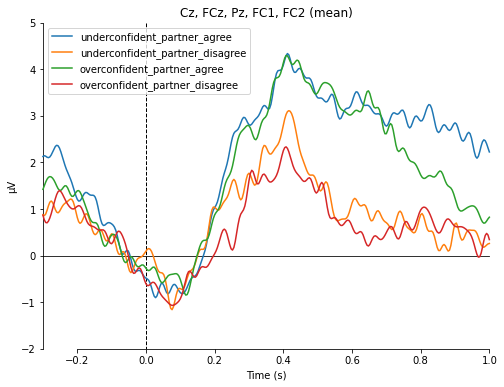

[<Figure size 576x432 with 1 Axes>]

In [20]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)

mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=roi, invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))




## Low vs high confidence grand average 

In [21]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
partner_epochs.metadata['confidence_z_by_participant'] = partner_epochs.metadata['participant_confidence'].groupby(partner_epochs.metadata['participant']).transform(zscore)
        
median_confidence = partner_epochs.metadata['confidence_z_by_participant'].median()

# # then zscore by partner (check if this is okay to do like this!!!)
# partner_epochs.metadata['confidence_z_by_participant_by_partner'] = partner_epochs.metadata['confidence_z_by_participant'].groupby(partner_epochs.metadata['partner']).transform(zscore)


Identifying common channels ...
Identifying common channels ...


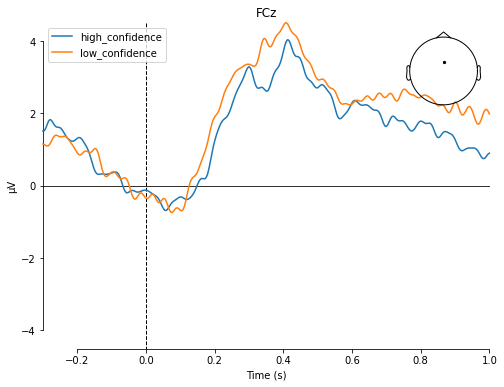

[<Figure size 576x432 with 2 Axes>]

In [22]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = partner_epochs['confidence_z_by_participant > 0']
low_conf_epochs = partner_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


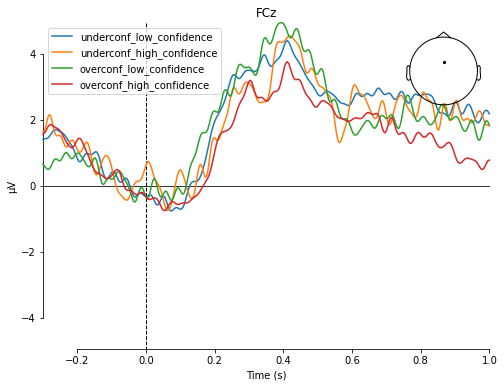

[<Figure size 576x432 with 2 Axes>]

In [23]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


# Observational condition

In [24]:
partner_epochs = partner_epochs_copy['condition == "ns"']

## agree vs disagree grand average (first calculating each participant's average)

Identifying common channels ...
Identifying common channels ...


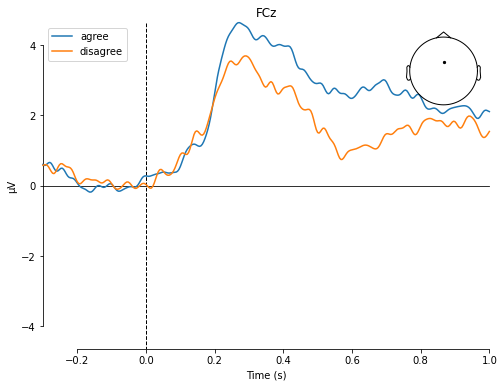

[<Figure size 576x432 with 2 Axes>]

In [25]:
grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())


grand_average_agree = mne.grand_average(grand_average_agree)
grand_average_disagree = mne.grand_average(grand_average_disagree)

evokeds = dict(agree=grand_average_agree,
               disagree=grand_average_disagree)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## agree vs disagree split by partner grand average 


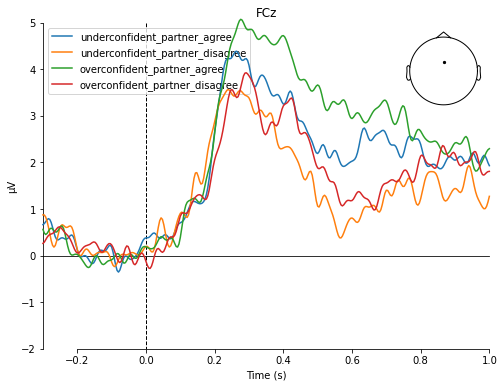

In [26]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)



fig = mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))
fig[0].savefig('Figures/observational_feedback_partner_FCz.pdf', bbox_inches='tight')


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\1280235701.py:30: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks='Pz', invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))


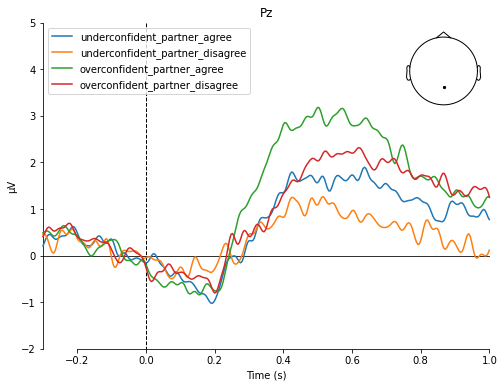

[<Figure size 576x432 with 2 Axes>]

In [27]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)

mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks='Pz', invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))




combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


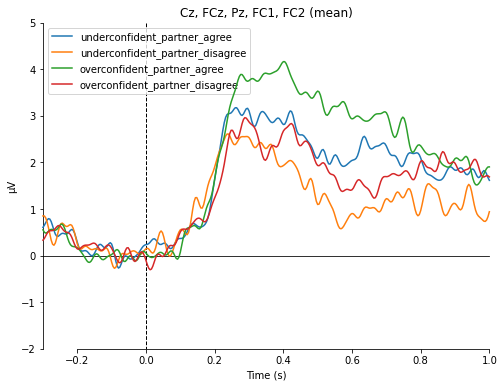

[<Figure size 576x432 with 1 Axes>]

In [28]:
grand_average_underconf_agree = []
grand_average_underconf_disagree = []
grand_average_overconf_agree = []
grand_average_overconf_disagree = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_agree_epochs = underconf_epochs['agreement == 1']
underconf_disagree_epochs = underconf_epochs['agreement == -1']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_agree_epochs = overconf_epochs['agreement == 1']
overconf_disagree_epochs = overconf_epochs['agreement == -1']





for subject in participant_numbers:    
    grand_average_underconf_disagree.append(underconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_underconf_agree.append(underconf_agree_epochs['participant == %i' % subject].average())
    grand_average_overconf_disagree.append(overconf_disagree_epochs['participant == %i' % subject].average())
    grand_average_overconf_agree.append(overconf_agree_epochs['participant == %i' % subject].average())
    

evokeds = dict(underconfident_partner_agree=grand_average_underconf_agree,
               underconfident_partner_disagree=grand_average_underconf_disagree,
               overconfident_partner_agree=grand_average_overconf_agree,
               overconfident_partner_disagree=grand_average_overconf_disagree)

mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=roi, invert_y=False, ci=False, ylim=dict(eeg=[-2, 5]))




## Low vs high confidence grand average 

In [29]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
partner_epochs.metadata['confidence_z_by_participant'] = partner_epochs.metadata['participant_confidence'].groupby(partner_epochs.metadata['participant']).transform(zscore)
        
median_confidence = partner_epochs.metadata['confidence_z_by_participant'].median()

# # then zscore by partner (check if this is okay to do like this!!!)
# partner_epochs.metadata['confidence_z_by_participant_by_partner'] = partner_epochs.metadata['confidence_z_by_participant'].groupby(partner_epochs.metadata['partner']).transform(zscore)


Identifying common channels ...
Identifying common channels ...


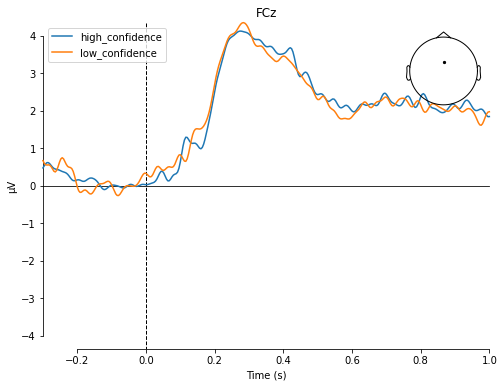

[<Figure size 576x432 with 2 Axes>]

In [30]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = partner_epochs['confidence_z_by_participant > 0']
low_conf_epochs = partner_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


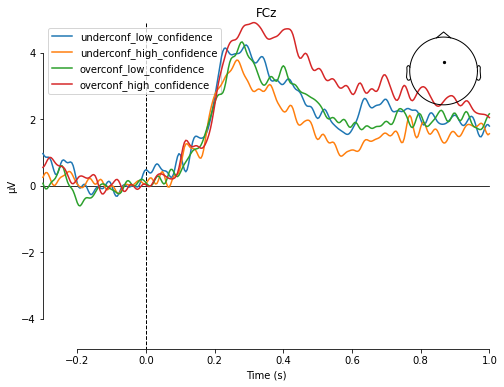

[<Figure size 576x432 with 2 Axes>]

In [31]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = partner_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = partner_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['FCz'], invert_y=False)


## Correlations between agreement and indiviudal electrodes



----------------------- Participant 1 -----------------------


>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\1_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\1_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


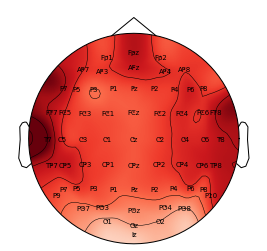


 Maximum correlation with confidence is at T7 with 0.151

 high vs low confidence at the channel that max correlates with confidence


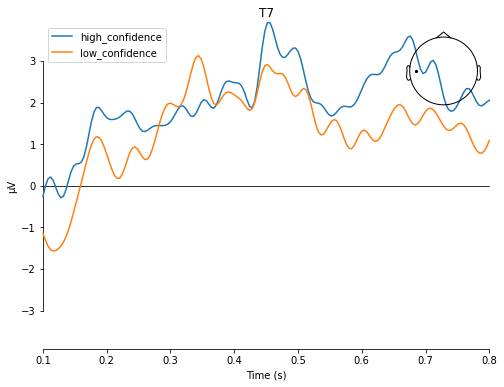



----------------------- Participant 2 -----------------------


>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\2_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\2_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
288 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


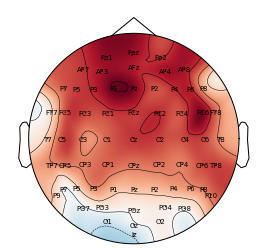


 Maximum correlation with confidence is at F1 with 0.162

 high vs low confidence at the channel that max correlates with confidence


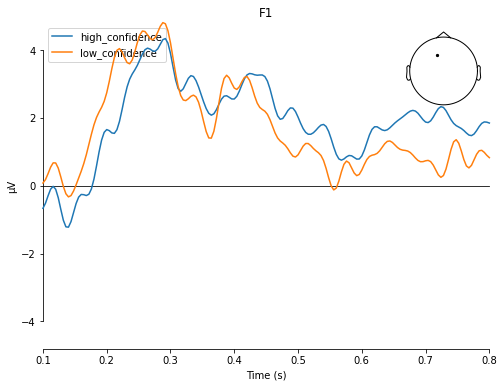



----------------------- Participant 3 -----------------------


>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\3_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
295 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\3_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


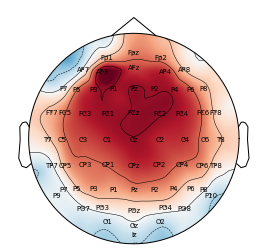


 Maximum correlation with confidence is at AF3 with 0.069

 high vs low confidence at the channel that max correlates with confidence


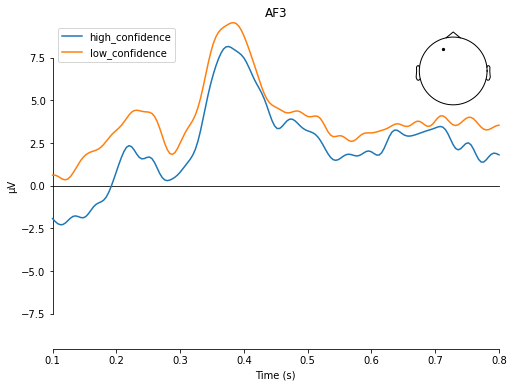



----------------------- Participant 4 -----------------------


>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\4_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
298 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\4_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


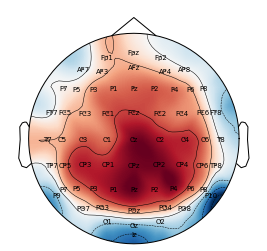


 Maximum correlation with confidence is at Pz with 0.117

 high vs low confidence at the channel that max correlates with confidence


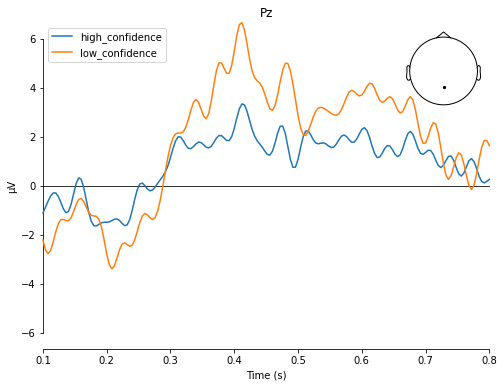



----------------------- Participant 5 -----------------------


>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\5_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\5_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


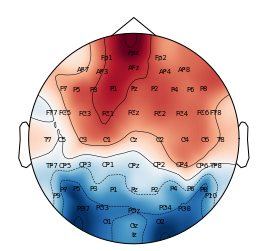


 Maximum correlation with confidence is at Fpz with 0.086

 high vs low confidence at the channel that max correlates with confidence


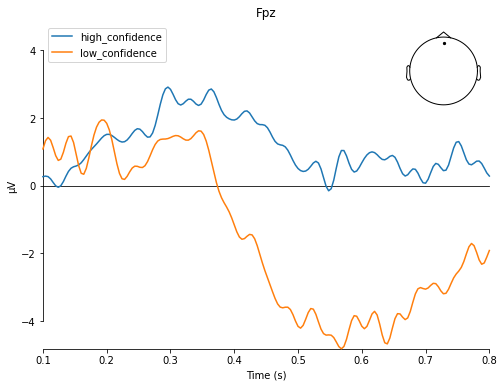



----------------------- Participant 6 -----------------------


>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\6_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
297 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\6_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


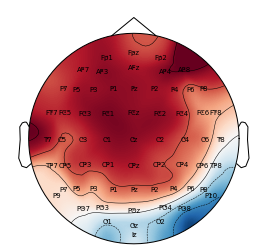


 Maximum correlation with confidence is at AF8 with 0.157

 high vs low confidence at the channel that max correlates with confidence


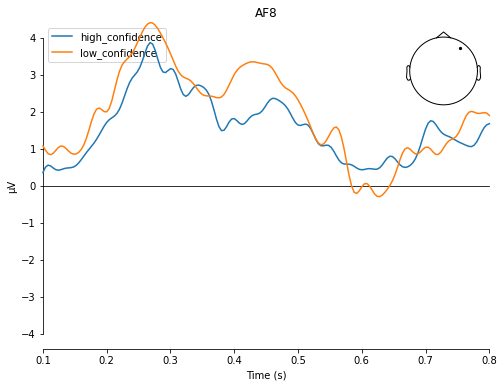



----------------------- Participant 7 -----------------------


>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\7_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
286 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\7_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
285 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


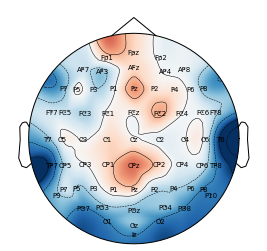


 Maximum correlation with confidence is at CPz with 0.070

 high vs low confidence at the channel that max correlates with confidence


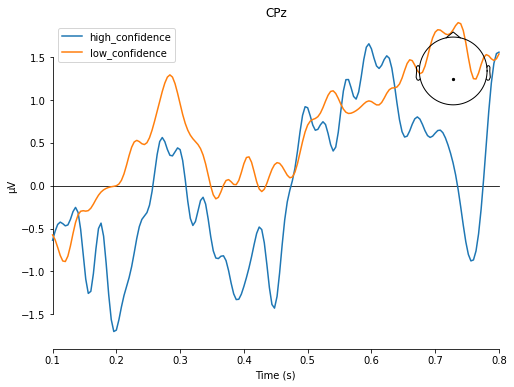



----------------------- Participant 8 -----------------------


>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\8_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
298 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\8_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


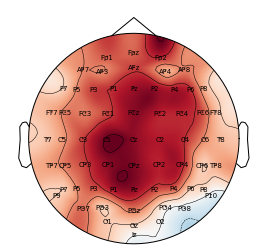


 Maximum correlation with confidence is at C1 with 0.163

 high vs low confidence at the channel that max correlates with confidence


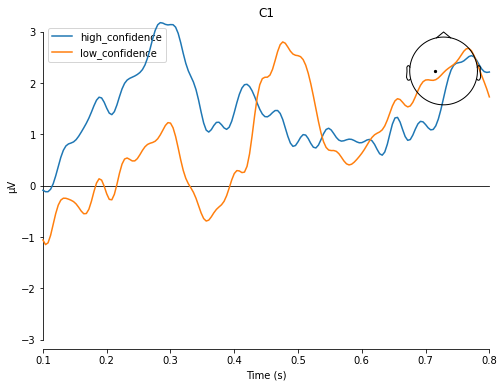



----------------------- Participant 9 -----------------------


>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\9_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\9_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
288 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51 colu

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


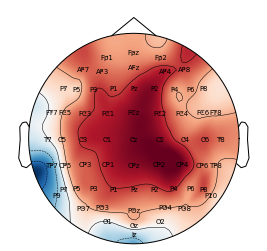


 Maximum correlation with confidence is at CP2 with 0.111

 high vs low confidence at the channel that max correlates with confidence


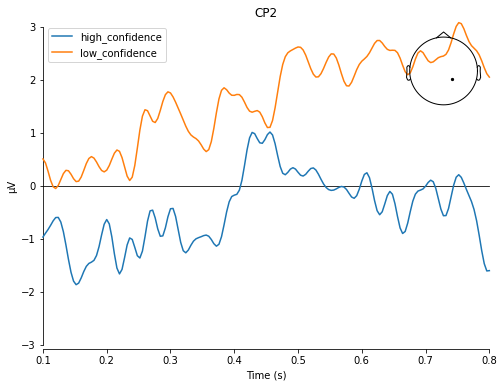



----------------------- Participant 10 -----------------------


>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\10_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
294 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\10_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
291 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


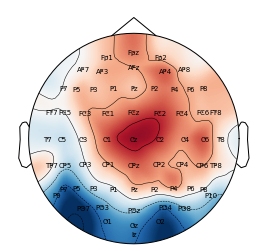


 Maximum correlation with confidence is at Cz with 0.089

 high vs low confidence at the channel that max correlates with confidence


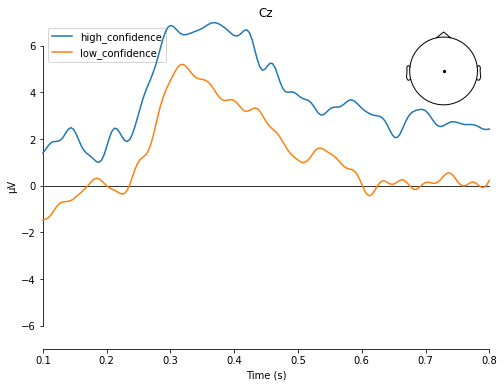



----------------------- Participant 11 -----------------------


>>> Loading TaskpartnerEpochsMastoids/11_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\11_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/11_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\11_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


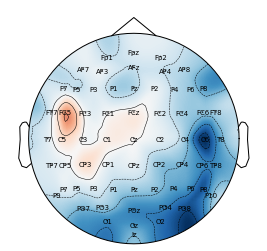


 Maximum correlation with confidence is at FC5 with 0.040

 high vs low confidence at the channel that max correlates with confidence


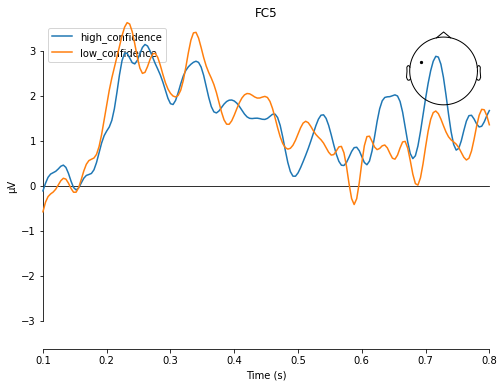



----------------------- Participant 12 -----------------------


>>> Loading TaskpartnerEpochsMastoids/12_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\12_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/12_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\12_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


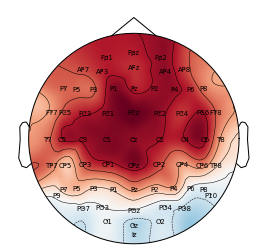


 Maximum correlation with confidence is at FCz with 0.144

 high vs low confidence at the channel that max correlates with confidence


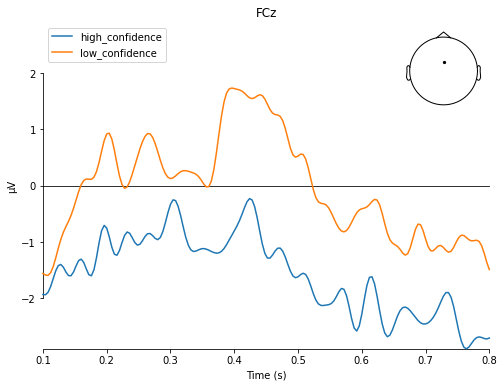



----------------------- Participant 13 -----------------------


>>> Loading TaskpartnerEpochsMastoids/13_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\13_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/13_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\13_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


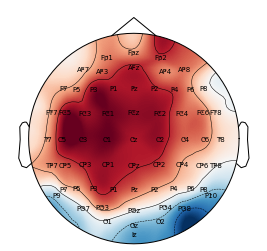


 Maximum correlation with confidence is at C1 with 0.132

 high vs low confidence at the channel that max correlates with confidence


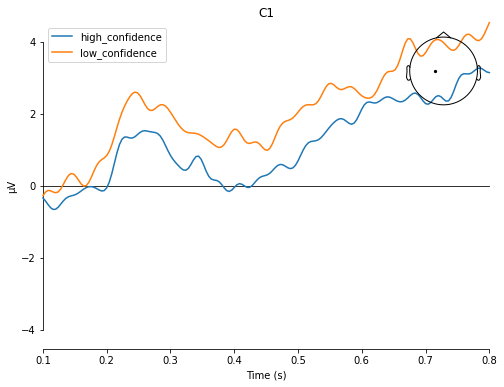



----------------------- Participant 15 -----------------------


>>> Loading TaskpartnerEpochsMastoids/15_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\15_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/15_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\15_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


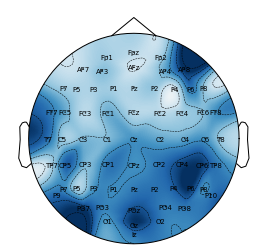


 Maximum correlation with confidence is at F4 with -0.010

 high vs low confidence at the channel that max correlates with confidence


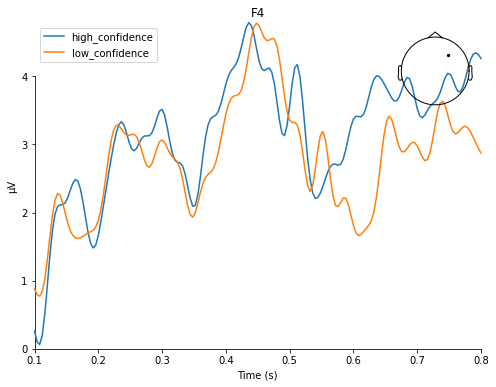



----------------------- Participant 16 -----------------------


>>> Loading TaskpartnerEpochsMastoids/16_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\16_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
290 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/16_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\16_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
256 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


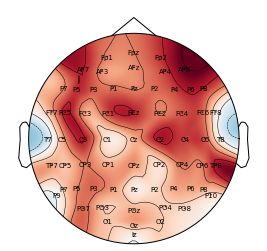


 Maximum correlation with confidence is at AF8 with 0.078

 high vs low confidence at the channel that max correlates with confidence


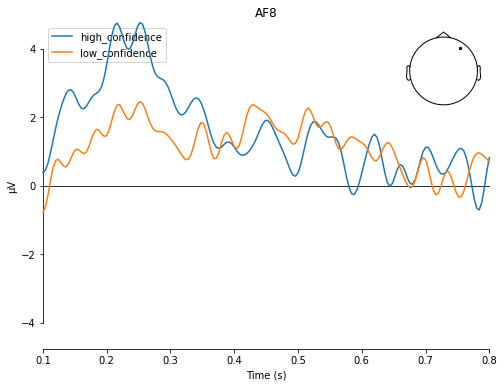



----------------------- Participant 17 -----------------------


>>> Loading TaskpartnerEpochsMastoids/17_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\17_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/17_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\17_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


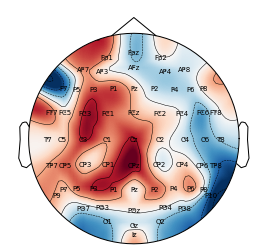


 Maximum correlation with confidence is at CPz with 0.050

 high vs low confidence at the channel that max correlates with confidence


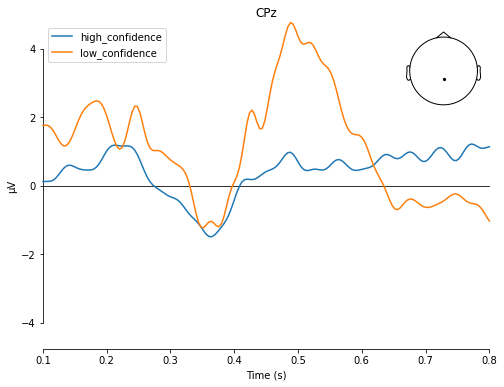



----------------------- Participant 18 -----------------------


>>> Loading TaskpartnerEpochsMastoids/18_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\18_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
297 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/18_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\18_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


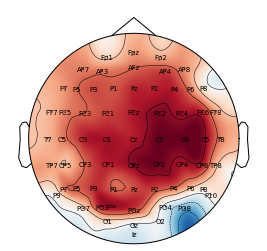


 Maximum correlation with confidence is at C4 with 0.135

 high vs low confidence at the channel that max correlates with confidence


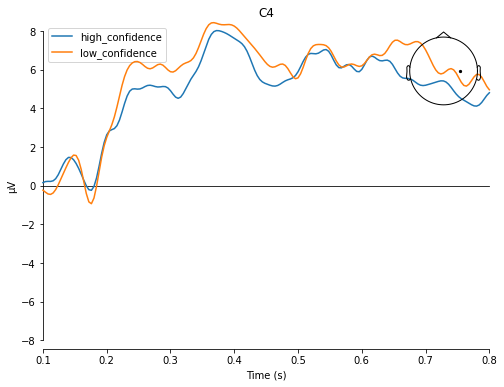



----------------------- Participant 19 -----------------------


>>> Loading TaskpartnerEpochsMastoids/19_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\19_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
299 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/19_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\19_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
300 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


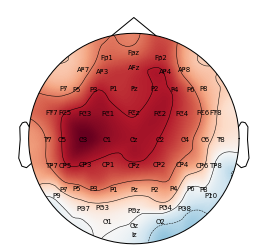


 Maximum correlation with confidence is at C3 with 0.151

 high vs low confidence at the channel that max correlates with confidence


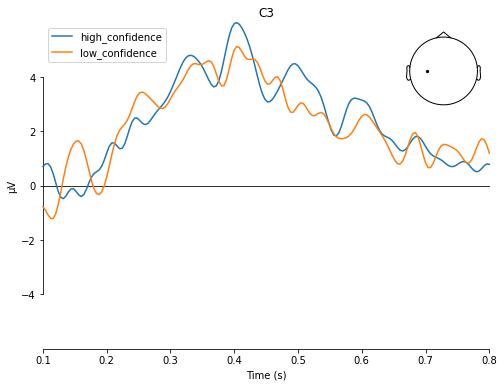



----------------------- Participant 20 -----------------------


>>> Loading TaskpartnerEpochsMastoids/20_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\20_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
298 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/20_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\20_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
295 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


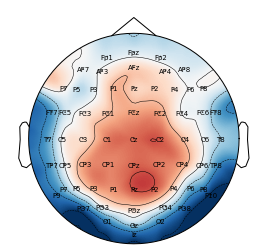


 Maximum correlation with confidence is at Pz with 0.061

 high vs low confidence at the channel that max correlates with confidence


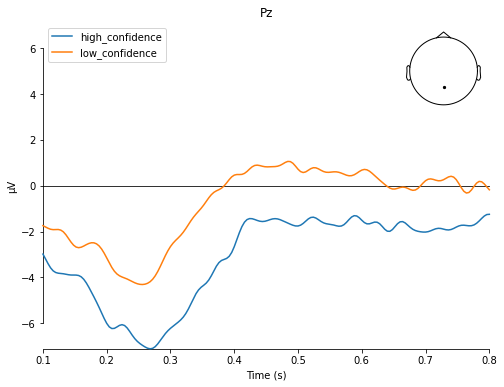



----------------------- Participant 21 -----------------------


>>> Loading TaskpartnerEpochsMastoids/21_1-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\21_1-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
293 matching events found
No baseline correction applied
0 projection items activated
>>> Loading TaskpartnerEpochsMastoids/21_2-epo.fif
Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\TaskpartnerEpochsMastoids\21_2-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 51 columns
276 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 51

C:\Users\majaf\AppData\Local\Temp\ipykernel_29380\3505007242.py:11: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.epochs.concatenate_epochs(subject_epochs)


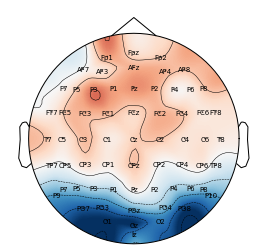


 Maximum correlation with confidence is at F3 with 0.049

 high vs low confidence at the channel that max correlates with confidence


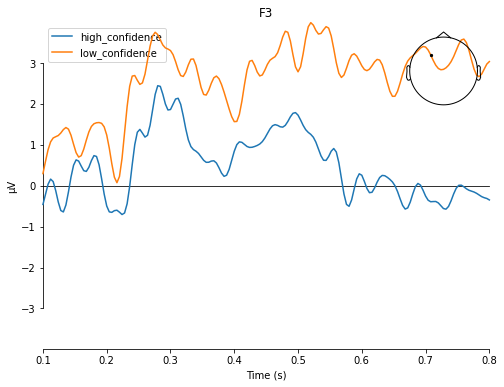

In [32]:
epoch_start = 0.1
epoch_end = 0.8

participant_corrs = []

for subject in participant_numbers:   
    print('\033[1m' + "\n\n----------------------- Participant %i -----------------------\n" % subject)
    print('\033[0m')
    
    # merge response epochs from both sessions for the participant
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (subject, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    
    # crop epochs
    epochs = epochs.crop(tmin=epoch_start, tmax=epoch_end, include_tmax=True)
    
    # independent variables
    # get epoched data as a numpy array of shape (n_epochs, n_channels, n_times)
    # crop epochs for correlation computation
    X = epochs.get_data()
    
    # get epoch average for each channel (average across timepoints) (n_epochs, n_channels)
    X = np.mean(X, 2)

    # dependent variable as numpy array (n_epochs,)
    y = epochs.metadata['agreement'].to_numpy()
    
    # compute correlation of every channel with agreement
    all_corrs = []
    for channel in range (X.shape[1]):
        x = X[:, channel]
        cor = np.corrcoef(y, x)[0, 1]
        all_corrs.append(cor)
    max_index = np.argmax(all_corrs)
    
    
    # plot topoploy of correlations
    print("Correlation of each channel with confidence \n\n")
    mne.viz.plot_topomap(data=all_corrs , pos=epochs.info, names=epochs.ch_names, show_names=True)
    
    
    print("\n Maximum correlation with confidence is at %s with %.3f" %(epochs.ch_names[max_index], max(all_corrs)))

    
    participant_corrs.append(all_corrs)
    

    # plot high vs low confidence at the channel that max correlates with confidence
    print("\n high vs low confidence at the channel that max correlates with confidence")
    median_confidence = epochs.metadata['participant_confidence'].median()
    low_conf_evoked = epochs['participant_confidence <= %i' % median_confidence].average()
    high_conf_evoked = epochs['participant_confidence > %i' % median_confidence].average()
    evokeds = dict(high_confidence=high_conf_evoked, low_confidence=low_conf_evoked)
    mne.viz.plot_compare_evokeds(evokeds, picks=[epochs.ch_names[max_index]], invert_y=False)


participant_correlations = np.array(participant_corrs)

In [33]:
average_participant_correlations = np.mean(participant_correlations, 0)
average_participant_correlations

array([ 0.05236044,  0.04019128,  0.05198778,  0.06675967,  0.05938917,
        0.04608406,  0.03192619,  0.02967785,  0.05141315,  0.05861977,
        0.06875415,  0.07046505,  0.06362526,  0.04910241,  0.02841034,
        0.02059418,  0.03586305,  0.05385117,  0.06110509,  0.04195742,
        0.03987537,  0.02465305,  0.00481247, -0.01061011, -0.01217118,
        0.01099799, -0.02127611, -0.03562595, -0.02329738,  0.00701309,
        0.04530026,  0.07061923,  0.05212998,  0.0513222 ,  0.04575457,
        0.05721153,  0.06069677,  0.06910351,  0.06637719,  0.06040437,
        0.04673344,  0.02981831,  0.02496449,  0.04672613,  0.05618335,
        0.0727555 ,  0.07251981,  0.07264612,  0.06997669,  0.05814538,
        0.04487642,  0.01729701,  0.01133919,  0.03239863,  0.04842429,
        0.05804385,  0.03789241,  0.03264518,  0.0093563 , -0.00595745,
       -0.02379621, -0.0342953 , -0.00681811, -0.03091339])

In [34]:
np.max(average_participant_correlations)

0.07275549987515165


 Average correlation of each channel with agreement across participants


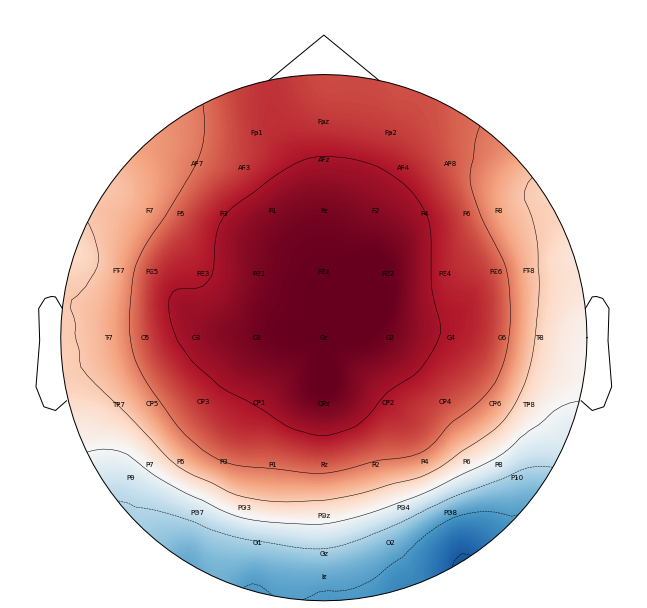

In [35]:
plt.rcParams['figure.figsize'] = [20, 10]
print("\n Average correlation of each channel with agreement across participants")
mne.viz.plot_topomap(data=average_participant_correlations , pos=epochs.info, names=epochs.ch_names, show_names=True)
import matplotlib.pyplot as plt

In [36]:
max(average_participant_correlations)

0.07275549987515165

In [37]:
largest = epochs.ch_names[average_participant_correlations.argsort()[-1]]
largest

'FC2'

In [38]:
second_largest = epochs.ch_names[average_participant_correlations.argsort()[-2]]
second_largest

'Cz'

In [39]:
third_largest = epochs.ch_names[average_participant_correlations.argsort()[-3]]
third_largest

'FCz'

In [40]:
fourth_largest = epochs.ch_names[average_participant_correlations.argsort()[-4]]
fourth_largest

'CPz'

In [41]:
fifth_largest = epochs.ch_names[average_participant_correlations.argsort()[-5]]
fifth_largest

'C1'

### Compute average voltage across roi for every trial

In [ ]:
roi = ["Cz", "FCz", "Pz", "FC1", "FC2"]

In [ ]:
color_dict = {'agree':'green', 'disagree':'red'}

grand_average_agree = []
grand_average_disagree = []

agree_epochs = partner_epochs['agreement == 1']
disagree_epochs = partner_epochs['agreement == -1']

for subject in participant_numbers:
    grand_average_agree.append(agree_epochs['participant == %i' % subject].average())
    grand_average_disagree.append(disagree_epochs['participant == %i' % subject].average())


mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=roi, invert_y=False, colors=color_dict, 
                             ci=False, ylim=dict(eeg=[-1, 4]), vlines=[epoch_start, epoch_end])

In [ ]:
roi_indices = [47, 46, 30, 10, 45]

In [ ]:
#%capture

for subject in participant_numbers:   

    # merge stimulus epochs from both sessions for the participant
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (subject, session))
    epoch = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    
    # crop epochs
    epoch = epoch.crop(tmin=epoch_start, tmax=epoch_end, include_tmax=True)

    # get epoched data as a numpy array of shape (n_epochs, n_channels, n_times)
    X = epoch.get_data()
    
    Cz = X[:, roi_indices[0], :]
    Cz_trial_average = np.mean(Cz, 1) # average across timepoints
    
    FCz = X[:, roi_indices[1], :]
    FCz_trial_average = np.mean(FCz, 1)
    
    Pz = X[:, roi_indices[2], :]
    Pz_trial_average = np.mean(Pz, 1)
    
    FC1= X[:, roi_indices[3], :]
    FC1_trial_average = np.mean(FC1, 1)
    
    FC2 = X[:, roi_indices[4], :]
    FC2_trial_average = np.mean(FC2, 1)
    
    agree_amplitude=[]
    for i in range(Cz_trial_average.shape[0]):
        trial_amplitude = (Cz_trial_average[i]+FCz_trial_average[i]+Pz_trial_average[i]+FC1_trial_average[i]+FC2_trial_average[i])/5
        agree_amplitude.append(trial_amplitude)
        
    epoch.metadata["agree_amplitude"] = agree_amplitude
    
    
    df = epoch.metadata
    df.to_csv('metadata_agree/participant_%i.csv' %subject)